In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import expm1
from scipy.special import j0 as B0
from scipy.special import j1 as B1
from scipy.special import sici

In [7]:
def sas_j1x_x(x):
    if np.isclose(x, 0.0):
        return 1.0
    else:
        return B1(x)/x

def sas_sinx_x(x):
    x_ = x/np.pi
    return np.sinc(x_)
    
def sas_j0x(x):
    return B0(x)   

def get_contrasts(d):
    rho_solv = 1

    if d==1:
        # Homogenous
        rho_s = rho_solv+1
        rho_c = rho_solv+1
    if d==2:
        # Shell
        rho_s = rho_solv
        rho_c = rho_solv+1
    if d==3:
        # core
        rho_s = rho_solv+1
        rho_c = rho_solv

    return rho_solv, rho_s, rho_c

# Example (units in Å)
Vc = 4000
Vs = 4000
eps = 2
R = 40
L = 100
N = 67
Rg = 10
d = 1.0
rho_solv, rho_s, rho_c = get_contrasts(2)
V_total = N*(Vs+Vc) 

In [14]:
def sas_six_x(x):
    si_x,_ = sici(x)
    if np.isclose(x, 0.0):
        return 1.0
    else:
        return si_x/x     

In [9]:
def micelle_warmlike_kernel(q,
        v_core=None,
        v_corona=None,
        v_total=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        length_core=None,
        d_penetration=None,
        n_aggreg=None):
    
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)

    # Self-correlation term of the core
    bes_core = 2*sas_j1x_x(q*radius_core)
    Fcs = bes_core**2
    qL = q*(length_core + 2*d_penetration*rg)
    Fl = 2*sas_six_x(qL) - sas_sinx_x(qL/2)**2
    Fs = Fcs*Fl
    term1 = np.power(n_aggreg*beta_core, 2)*Fs

    # Self-correlation term of the chains
    qrg2 = np.power(q*rg, 2)
    debye_chain = 1.0 if qrg2==0.0 else 2.0*(expm1(-qrg2)+qrg2)/(qrg2**2)
    term2 = n_aggreg * (beta_corona**2) * debye_chain

    # Interference cross-term between core and chains
    qrg = q*rg
    chain_ampl =  1.0 if qrg==0.0 else -expm1(-qrg)/qrg
    bes_corona = sas_j0x(q*(radius_core + d_penetration*rg))
    Ssc = chain_ampl*bes_core*bes_corona*Fl
    term3 = 2.0 * (n_aggreg**2) * beta_core * beta_corona * Ssc

    # Interference cross-term between chains
    Scc = (chain_ampl**2) * (bes_corona**2) * Fl
    term4 = n_aggreg * (n_aggreg - 1.0)* (beta_corona**2)*Scc

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4

    # Normalize intensity by total volume
    return i_micelle/v_total

Computing l = 200.000 Å...
Computing l = 400.000 Å...
Computing l = 1000.000 Å...
Computing l = 10000.000 Å...


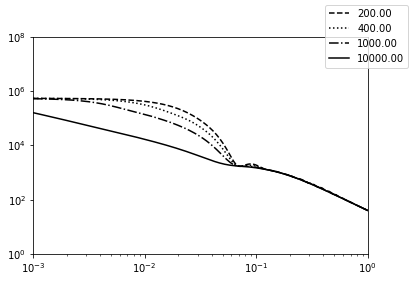

In [20]:
fig, ax = plt.subplots()
lengths = [200.0, 400.0, 1000.0, 10000.0]
linestyles = ['dashed','dotted','dashdot', 'solid' ]
rho_solv, rho_s, rho_c = get_contrasts(1)

for i,l in enumerate(lengths):
    print('Computing l = %.3f Å...'%l)
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': l,
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-3), np.log10(1), 200)
    Iq_micelle = np.asarray([micelle_warmlike_kernel(qi, **params) for qi in q])
    ax.loglog(q, Iq_micelle, label='%.2f'%l, ls=linestyles[i], color='k')
    ax.set_ylim([1e0, 1e8])
    ax.set_xlim([1e-3, 1e0])
fig.legend()
plt.show()

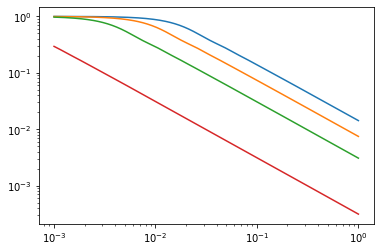

In [23]:
def compute_fl(q, l, d, rg):
    qL = q*(l + 2*d*rg)
    Fl = 2*sas_six_x(qL) - sas_sinx_x(0.5*qL)**2

    return Fl 

Fl_200 = np.asarray([compute_fl(qi, 200, d, Rg) for qi in q])
Fl_400 = np.asarray([compute_fl(qi, 400, d, Rg) for qi in q])
Fl_1000 = np.asarray([compute_fl(qi, 1000, d, Rg) for qi in q])
Fl_10000 = np.asarray([compute_fl(qi, 10000, d, Rg) for qi in q])

fig, ax = plt.subplots()
ax.loglog(q, Fl_200)
ax.loglog(q, Fl_400)
ax.loglog(q, Fl_1000)
ax.loglog(q, Fl_10000)
plt.show()